In [41]:
import QuantLib as ql
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as spo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from random import sample
import sklearn.neural_network as sknn
import matplotlib.pyplot as plt
import time
from scipy.integrate import *
import cmath as cpx
import math as m
from sklearn.metrics import mean_squared_error
from copy import deepcopy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def MakeUniformRandParams(ArrayMin,ArrayMax,nRand):
    if (len(ArrayMin)!=len(ArrayMax)):
        raise Exception('ArrayMax and ArrayMin must have the same size')
    else:
        nParams = len(ArrayMin)
        rand_seq = ql.UniformRandomSequenceGenerator(nParams*nRand,ql.UniformRandomGenerator())
        X = rand_seq.nextSequence().value()
        #X = [ArrayMin[j%nParams]+(ArrayMax[j%nParams]-ArrayMin[j%nParams])*X[j] for j in range(nParams*nRand)]
        res = np.zeros((nRand,nParams))
        LocalMax = 0
        res__ = 0
        res_ = 0
        for i in range(nRand):
            for j in range(nParams):
                AdjMax = ArrayMax[j]
                if j==2:
                    AdjMax = XiFellerAdjust(res__,res_,ArrayMax[j])
                res[i,j]=ArrayMin[j]+(AdjMax-ArrayMin[j])*X[i*nParams+j]
                res__ = res_
                res_ = res[i,j]
        #res = np.reshape(X,(nRand,nParams))
        return res

def CountNoFellerCondition(X):
    k=0
    for j in range(len(X)):
        if (X[j,2]>XiFellerMax(X[j,0],X[j,1])):
            k=k+1
    return k

def XiFellerMax(kappa,theta):
    return m.sqrt(2*kappa*theta)

def XiFellerAdjust(kappa,theta,xi_init):
    if (xi_init>XiFellerMax(kappa,theta)):
        return XiFellerMax(kappa,theta)
    return xi_init
    
ArrayMin = [0.1, 0.1,  0.01, -0.999, 0.1]
ArrayMax = [1.5, 1.5,  0.75,  0.999, 1.5]
nRand = 100000
start = time.time()
res=MakeUniformRandParams(ArrayMin,ArrayMax,nRand)
end = time.time()
print('Total computation time = ' + str(round(end-start,2)) + 's')
print('No Feller Condition ' + str(CountNoFellerCondition(res)))

Total computation time = 0.83s
No Feller Condition 0


In [3]:
# GLOBAL CONFIG #
AsOfDate = ql.Date(15,10,2018)
ql.Settings.instance().evaluationDate = AsOfDate
DayCount = ql.Actual365Fixed()
Calendar = ql.UnitedStates()

In [4]:
# EUROPEAN OPTION CONFIG #
MaturityDates = []
strikes = []
exercises = []
payoffs = []
option_type = ql.Option.Call
ms = [1,2,3,6,0,6,0,0,0,0]
ys = [0,0,0,0,1,1,2,3,4,5]
for k in range(len(ms)):
    if (10+ms[k]>12):
        ys_sup=1
    else:
        ys_sup=0
    MaturityDates.append(ql.Date(15,(10+ms[k]-1)%12+1,2018+ys[k]+ys_sup))
    exercises.append(ql.EuropeanExercise(MaturityDates[k]))
for k in range(7):
        strikes.append(70+k*10)
        #payoffs.append(ql.PlainVanillaPayoff(option_type, strikes[k]))
print(MaturityDates)
print(strikes)
EuropeanOptions = []
for K in range(len(strikes)):
    for T in range(len(MaturityDates)):
        EuropeanOptions.append(ql.VanillaOption(ql.PlainVanillaPayoff(option_type,100-(100-strikes[K])*m.sqrt((MaturityDates[T]-AsOfDate)/365)), exercises[T]))
#print(EuropeanOptions)

[Date(15,11,2018), Date(15,12,2018), Date(15,1,2019), Date(15,4,2019), Date(15,10,2019), Date(15,4,2020), Date(15,10,2020), Date(15,10,2021), Date(15,10,2022), Date(15,10,2023)]
[70, 80, 90, 100, 110, 120, 130]


In [5]:
def d1(S0, K, r, sigma, T):
    m = S0/(K*np.exp(-r*T))
    return np.log(m)*(1/(sigma*np.sqrt(T)))+sigma*np.sqrt(T)/2

def d2(S0, K, r, sigma, T):
    return d1(S0,K,r,sigma,T)-sigma*np.sqrt(T)
 
def BS_CallPrice(S0,K,r,sigma,T):
    if T==0:
        return np.maximum(S0-K,0)
    else:
        return S0*stats.norm.cdf(d1(S0,K,r,sigma,T))-K*np.exp(-r*T)*stats.norm.cdf(d2(S0,K,r,sigma,T))

def Heston_CharacteristicFunctionLogPrice(t,omega,S0,v0,r,kappa,theta,ksi,rho):
    alpha = complex(-omega**2 / 2, -omega / 2)
    beta = complex(kappa,-rho*ksi*omega)
    gamma = ksi**2 / 2
    h = (beta**2-4*alpha*gamma)**0.5
    r_m = (beta-h) / ksi**2
    r_p = (beta+h) / ksi**2
    g = r_m / r_p
    C = kappa*(r_m*t-2*cpx.log((1-g*cpx.exp(-h*t))/(1-g))/ksi**2)
    D = r_m*((1-cpx.exp(-h*t))/(1-g*cpx.exp(-h*t)))
    return cpx.exp(complex(C*theta+D*v0,omega*np.log(S0*np.exp(r*t))))

def RPI1_HestonChFuncLnS(omega,K,t,S0,v0,r,kappa,theta,ksi,rho):
    num = Heston_CharacteristicFunctionLogPrice(t,omega-complex(0,1),S0,v0,r,kappa,theta,ksi,rho)*cpx.exp(complex(0,-omega*np.log(K)))
    denom = complex(0,omega*Heston_CharacteristicFunctionLogPrice(t,-complex(0,1),S0,v0,r,kappa,theta,ksi,rho))
    return (num / denom).real
def RPI2_HestonChFuncLnS(omega,K,t,S0,v0,r,kappa,theta,ksi,rho):
    num = Heston_CharacteristicFunctionLogPrice(t,omega,S0,v0,r,kappa,theta,ksi,rho)*cpx.exp(complex(0,-omega*np.log(K)))
    denom = complex(0,omega)
    return (num / denom).real
def Heston_CallPrice(K,S0,r,T,v0,kappa,theta,ksi,rho):
    Pi_1 = 1/2+1/np.pi*quad(RPI1_HestonChFuncLnS,0,np.inf,args=(K,T,S0,v0,r,kappa,theta,ksi,rho))[0]
    Pi_2 = 1/2+1/np.pi*quad(RPI2_HestonChFuncLnS,0,np.inf,args=(K,T,S0,v0,r,kappa,theta,ksi,rho))[0]
    return S0*Pi_1-K*np.exp(-r*T)*Pi_2

def IVol(Mkt,S0,K,r,T,vol0=0.1):
    def f(vol,Mkt_,S0_,K_,r_,T_,type_): return (BS_CallPrice(S0_,K_,r_,vol,T_)-Mkt)**2
    return spo.minimize(f,vol0,args=(Mkt,S0,K,r,T,type),tol=1.0e-10).x

In [6]:
#OLD
Expiries = [0.0833,0.1667,0.25,0.5,1,1.5,2,3,4,5]
BaseStrikes = [70,80,90,100,110,120,130]
Strikes = []
for K in range(len(BaseStrikes)):
    for T in range(len(Expiries)):
        Strikes.append(100-(100-BaseStrikes[K])*m.sqrt(Expiries[T])) 

In [7]:
# MARKET DATA
r=ql.SimpleQuote(0.01)
r_ts = ql.FlatForward(0,Calendar,ql.QuoteHandle(r),DayCount)
q=ql.SimpleQuote(0.0)
q_ts = ql.FlatForward(0,Calendar,ql.QuoteHandle(q),DayCount)
s0=ql.SimpleQuote(100)

# BLACK SCHOLES ENGINE ONLY USED FOR COMPUTING IMPLIED VOLATILITIES
vol_bs = ql.SimpleQuote(0.10)
vol_bs_ts = ql.BlackConstantVol(0,Calendar,ql.QuoteHandle(vol_bs),DayCount)
BSProcess = ql.BlackScholesMertonProcess(ql.QuoteHandle(s0),ql.YieldTermStructureHandle(r_ts),ql.YieldTermStructureHandle(q_ts),
                               ql.BlackVolTermStructureHandle(vol_bs_ts))

# HESTON ENGINE
v0 = 0.01
kappa=0.5
theta=0.01
sigma=0.0001
rho=-0.5
HestonParams = [theta,kappa,sigma,rho,v0]
relTolerance=0.01
maxEval=10000
HestonProcess = ql.HestonProcess(ql.YieldTermStructureHandle(r_ts),ql.YieldTermStructureHandle(q_ts),
                                 ql.QuoteHandle(s0),v0,kappa,theta,sigma,rho)
HestonModel = ql.HestonModel(HestonProcess)
HestonEngine = ql.AnalyticHestonEngine(HestonModel,relTolerance,maxEval)
for i in range(len(EuropeanOptions)):
    EuropeanOptions[i].setPricingEngine(HestonEngine)

In [8]:
# GENERATE DATAS
nRand = 100000
start = time.time()
MinParamsValues = [0.1,0.1,0.1,-0.999,0.1]
MaxParamsValues = [2.5,0.6,1.5,-0.10,0.6]
local_start = 0
local_end = 0
ArrParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)
intermediary = time.time()

#npv = np.zeros(nRand)
#iv = np.zeros(nRand)
#for i in range(nRand):
#    HestonModel.setParams([ArrParams[i][k] for k in range(len(MinParamsValues))])
#    npv[i] = EuropeanOption.NPV()
#    iv[i] = EuropeanOption.impliedVolatility(npv[i],BSProcess,1.0e-4,200,1.0e-8,10)
#end = time.time()
#print('Random params simulation time = ' + str(round(intermediary-start,2)) + 's')
#print('Prices computation time = ' + str(round(end-intermediary,2)) + 's')
#print('Total computation time = ' + str(round(end-start,2)) + 's')
#X = np.zeros((nRand*len(Strikes),len(ArrParams[0])+2))
npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
for i in range(nRand):
    HestonModel.setParams([ArrParams[i,k] for k in range(len(MinParamsValues))])
    for j in range(len(EuropeanOptions)):
        npv = max(EuropeanOptions[j].NPV(),np.random.uniform(0,0.01))
        iv[i,j] = EuropeanOptions[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)
end = time.time()
print('Random params simulation time = ' + str(round(intermediary-start,2)) + 's')
print('Prices computation time = ' + str(round(end-intermediary,2)) + 's')
print('Total computation time = ' + str(round(end-start,2)) + 's')

Random params simulation time = 0.94s
Prices computation time = 1006.54s
Total computation time = 1007.48s


In [58]:
HestonPrice = EuropeanOptions[j].NPV()
time_=ql.Date(15,11,2018)-AsOfDate
print(time_)
print(EuropeanOptions[j])

31
<QuantLib.QuantLib.VanillaOption; proxy of <Swig Object of type 'VanillaOptionPtr *' at 0x00000263EC97A2D0> >


In [60]:
print(HestonPrice)
print('K = ' + str(strikes[j%len(strikes)]))
print('T = ' + str(MaturityDates[int(j/len(strikes))]))
print(ArrParams[i])
new_vol = 100
vol_bs.setValue(new_vol)
EuropeanOptions[j].setPricingEngine(ql.AnalyticEuropeanEngine(BSProcess))
print(EuropeanOptions[j].NPV())

97.3865967715769
K = 70
T = October 15th, 2028
[ 0.87791359  0.57905022  0.85163063 -0.6712743   0.47793902]
90.47630508934425


In [9]:
def ann_layers_neurones(layer, neurone):
    hidden_layer_sizes = (neurone, )
    if layer == 1.0: return hidden_layer_sizes
    elif layer > 1.0:
        for i in range(layer-1):
            hidden_layer_sizes += (neurone,)
        return hidden_layer_sizes

nLayersMin = 3
nLayersMax = 5
nLayersStep = 1
nNeuronesMin = 30
nNeuronesMax = 60
nNeuronesStep = 5
hidden_layers_sizes_vect = []
i_ = 0
for i in range(nNeuronesMin,nNeuronesMax+1,nNeuronesStep):
    j_ = 0
    for j in range(nLayersMin,nLayersMax+1,nLayersStep):
        hidden_layers_sizes_vect.append(ann_layers_neurones(j,i))
        j_ += 1
    i_ += 1
print(hidden_layers_sizes_vect)

[(30, 30, 30), (30, 30, 30, 30), (30, 30, 30, 30, 30), (35, 35, 35), (35, 35, 35, 35), (35, 35, 35, 35, 35), (40, 40, 40), (40, 40, 40, 40), (40, 40, 40, 40, 40), (45, 45, 45), (45, 45, 45, 45), (45, 45, 45, 45, 45), (50, 50, 50), (50, 50, 50, 50), (50, 50, 50, 50, 50), (55, 55, 55), (55, 55, 55, 55), (55, 55, 55, 55, 55), (60, 60, 60), (60, 60, 60, 60), (60, 60, 60, 60, 60)]


In [10]:
start = time.time()
n = nRand
ann = sknn.MLPRegressor(hidden_layer_sizes=(30,30,30))
array_train_rel_error = np.zeros((n,len(EuropeanOptions)))
array_test_rel_error = np.zeros((n,len(EuropeanOptions)))
array_train_abs_error = np.zeros((n,len(EuropeanOptions)))
array_test_abs_error = np.zeros((n,len(EuropeanOptions)))
index = sample(range(0,nRand),n)
X=np.zeros((n,len(ArrParams[0])))
for k in range(len(ArrParams[0])):        
    X[:,k]=[ArrParams[j,k] for j in index]
Y=[iv[j,:] for j in index]

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
X_train = X
Y_train = Y

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

# ANN FIT

mse_optim = 1000
ann_optim = deepcopy(ann)
for current_archi in hidden_layers_sizes_vect:
    ann.set_params(hidden_layer_sizes=current_archi)
    ann.fit(X_train,Y_train)
    train_prediction=ann.predict(X_train)
    mse=mean_squared_error(Y_train,train_prediction)
    print('current archi ' + str(current_archi) + ' ; mse = ' + str(mse))
    if (mse<mse_optim):
        mse_optim=mse
        print('I am optimal')
        ann_optim=deepcopy(ann)
        for i in range(len(X_train)):
            for j in range(len(EuropeanOptions)):
                array_train_abs_error[i,j]=(train_prediction[i,j]-Y_train[i][j])*100
                array_train_rel_error[i,j]=(train_prediction[i,j]/Y_train[i][j]-1)*100
            
            #for j in range(len(EuropeanOptions)):
                #if (i < len(X_train)):
                    #array_train_abs_error[i,j]=(train_prediction[i,j]-Y_train[i][j])*100
                    #array_train_rel_error[i,j]=(train_prediction[i,j]/Y_train[i][j]-1)*100
                #if (i < len(X_test)):
                    #array_test_abs_error[i,j]=(test_prediction[i,j]-Y_test[i][j])*100
                    #array_test_rel_error[i,j]=(test_prediction[i,j]/Y_test[i][j]-1)*100
        
        #test_prediction=ann.predict(X_test)
        #for i in range(max(len(X_train),len(X_test))):
            #for j in range(len(EuropeanOptions)):
                #if (i < len(X_train)):
                    #array_train_abs_error[i,j]=(train_prediction[i,j]-Y_train[i][j])*100
                    #array_train_rel_error[i,j]=(train_prediction[i,j]/Y_train[i][j]-1)*100
                #if (i < len(X_test)):
                    #array_test_abs_error[i,j]=(test_prediction[i,j]-Y_test[i][j])*100
                    #array_test_rel_error[i,j]=(test_prediction[i,j]/Y_test[i][j]-1)*100
end = time.time()
print('Total computation time = ' + str(round(end-start,2)) + 's')

current archi (30, 30, 30) ; mse = 8.365223625870351e-05
I am optimal
current archi (30, 30, 30, 30) ; mse = 6.985313825524427e-05
I am optimal
current archi (30, 30, 30, 30, 30) ; mse = 0.0001205150356052353
current archi (35, 35, 35) ; mse = 5.3254953669539e-05
I am optimal
current archi (35, 35, 35, 35) ; mse = 7.098382396275922e-05
current archi (35, 35, 35, 35, 35) ; mse = 8.474270488621364e-05
current archi (40, 40, 40) ; mse = 5.098183665998151e-05
I am optimal
current archi (40, 40, 40, 40) ; mse = 7.092876558561497e-05
current archi (40, 40, 40, 40, 40) ; mse = 5.6785016137725304e-05
current archi (45, 45, 45) ; mse = 5.5852878977589844e-05
current archi (45, 45, 45, 45) ; mse = 7.463006819962288e-05
current archi (45, 45, 45, 45, 45) ; mse = 6.861855097461862e-05
current archi (50, 50, 50) ; mse = 6.804177152078485e-05
current archi (50, 50, 50, 50) ; mse = 5.129162295123769e-05
current archi (50, 50, 50, 50, 50) ; mse = 5.990539606008592e-05
current archi (55, 55, 55) ; mse 

Text(0.5,1,'Maximum Absolute Error')

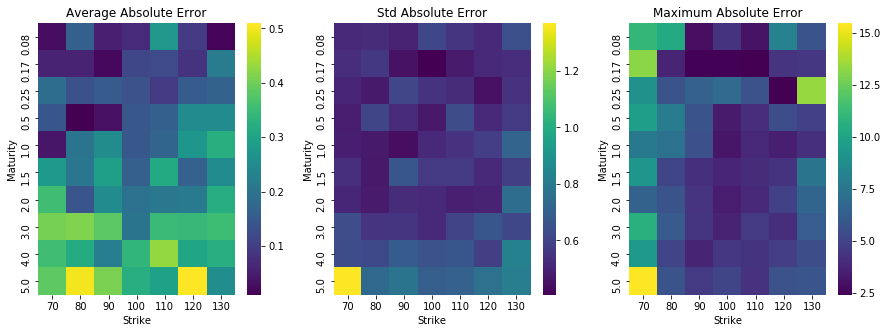

In [75]:
Expiries_ = np.zeros(len(Expiries))
for j in range(len(Expiries)):
    Expiries_[j] = round(Expiries[j],2)
plt.figure(figsize=(15,5))
plt.figure(1)

plt.subplot(131)
mean_abs_data = np.reshape(np.mean(array_train_abs_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_mean_abs = pd.DataFrame(mean_abs_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_mean_abs, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Average Absolute Error")

plt.subplot(132)
std_abs_data = np.reshape(np.std(array_train_abs_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_std_abs = pd.DataFrame(std_abs_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_std_abs, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Std Absolute Error")

plt.subplot(133)
max_abs_data = np.reshape(np.max(array_train_abs_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_max_abs = pd.DataFrame(max_abs_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_max_abs, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Maximum Absolute Error")

Text(0.5,1,'Maximum Relative Error')

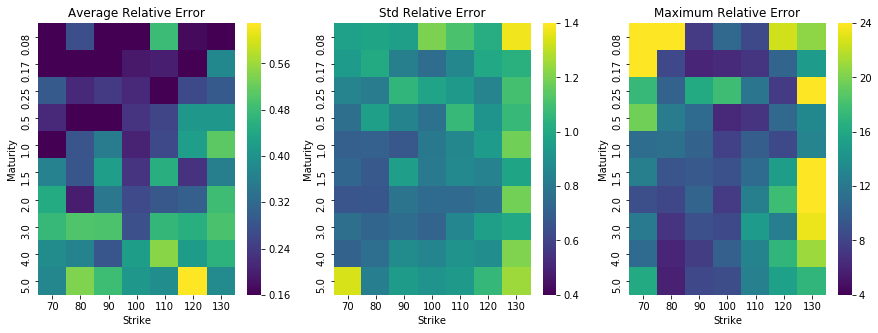

In [76]:
plt.figure(figsize=(15,5))
plt.figure(1)

plt.subplot(131)
mean_rel_data = np.reshape(np.mean(array_train_rel_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_mean_rel = pd.DataFrame(mean_rel_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_mean_rel, vmin=0.16, vmax=0.63, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Average Relative Error")

plt.subplot(132)
std_rel_data = np.reshape(np.std(array_train_rel_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_std_rel = pd.DataFrame(std_rel_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_std_rel, vmin=0.4, vmax=1.4, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Std Relative Error")

plt.subplot(133)
max_rel_data = np.reshape(np.max(array_train_rel_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_max_rel = pd.DataFrame(max_rel_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_max_rel, vmin=4, vmax=24, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Maximum Relative Error")

[[0.78249466 0.79121165 0.79857638 0.81615814 0.84512633 0.87078781
  0.89545603 0.94619289 1.00514761 1.08279223 0.77884854 0.78617463
  0.79199625 0.80639269 0.82994035 0.85035798 0.8694429  0.90622613
  0.94433755 0.98693457 0.77550826 0.78121995 0.7861139  0.79792449
  0.81747553 0.83447407 0.85022054 0.87997546 0.9095132  0.94063627
  0.77241087 0.77687216 0.7807914  0.79043052 0.80689855 0.82146718
  0.83506288 0.86070728 0.88582477 0.91160216 0.76951725 0.77285471
  0.77588715 0.78370486 0.79767752 0.81045162 0.8225551  0.84557833
  0.86806814 0.89091006 0.76678961 0.76909937 0.77135209 0.77765278
  0.78950627 0.80091525 0.81191123 0.83315596 0.85398435 0.87503766
  0.7642029  0.76554351 0.76711386 0.77199904 0.78214643 0.79245518
  0.80264469 0.82262945 0.84234819 0.86219492]]
[[0.78417197 0.79209463 0.80154994 0.81501574 0.84550038 0.87564264
  0.90030265 0.94945158 1.00539826 1.07749485 0.78352139 0.78881061
  0.79320371 0.80719101 0.82760881 0.85433089 0.86811143 0.90849156


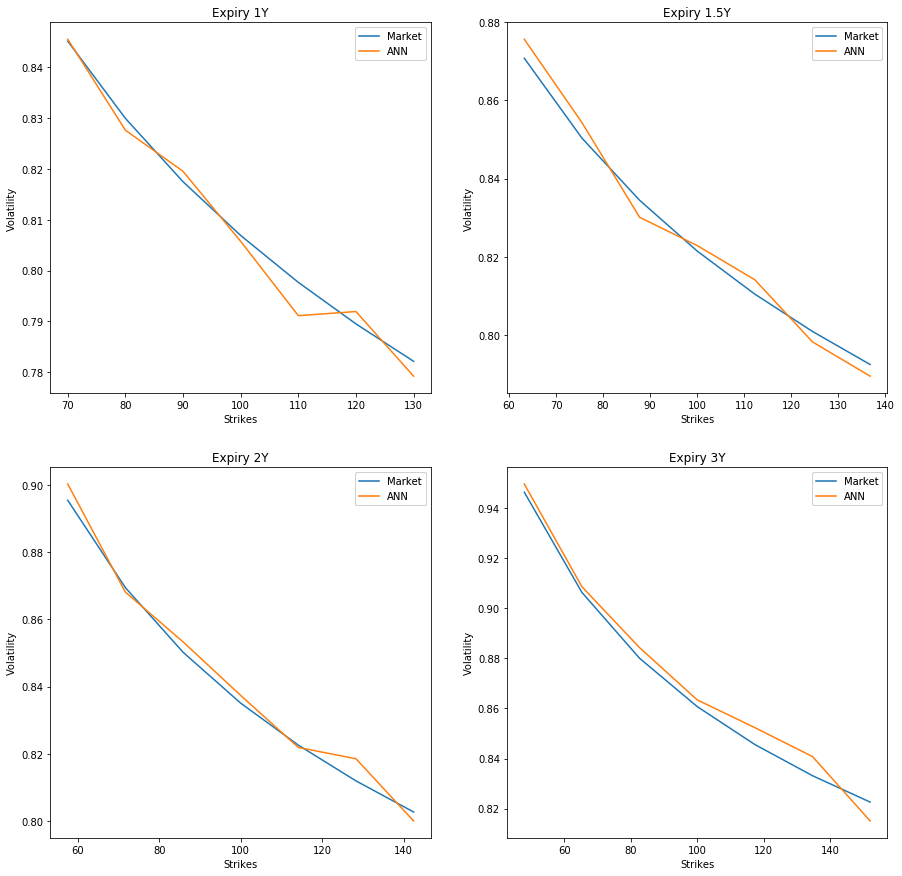

In [25]:
n = 1
index = sample(range(0,nRand),n)
X_ref=np.zeros((n,len(ArrParams[0])))
for k in range(len(ArrParams[0])):        
    X_ref[:,k]=[X_train[j,k] for j in index]
Y_ref=np.array(Y_train)[index,:]
Y_pred=ann.predict(X_ref)

print(Y_ref)
print(Y_pred)

X2 = np.reshape(np.tile(Expiries,len(BaseStrikes)),(len(BaseStrikes),len(Expiries)))
Y2 = np.reshape(np.array(Strikes),(len(BaseStrikes),len(Expiries)))

Z_INIT = np.reshape(Y_ref[0],(len(BaseStrikes),len(Expiries)))
Z_ANN = np.reshape(Y_pred[0],(len(BaseStrikes),len(Expiries)))
#print(X)
#print(Y)
#print(Z)
#surf = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)

plt.figure(figsize=(15,15))
plt.figure(1)
current_num=221
for k in range(4,8):
    plt.subplot(current_num)
    line1, = plt.plot(Y2[:,k],Z_INIT[:,k],label="Market")
    plt.xlabel("Strikes")
    plt.ylabel("Volatility")
    plt.title("Expiry " + str(round(Expiries[k],2)) + "Y")
    line2, = plt.plot(Y2[:,k],Z_ANN[:,k],label="ANN")
    plt.xlabel("Strikes")
    plt.ylabel("Volatility")
    plt.gca().add_artist(plt.legend(handles=[line1,line2]))
    #plt.gca().add_artist(plt.legend(handles=[line2],loc=7))
    current_num = current_num+1

plt.show()

In [77]:
def EvalANN(params,ann_,output_): return mean_squared_error(output_,ann_.predict([params]))
def InvertANN(ann,mkt,scaler,params0=[0.5,0.25,0.3,-0.5,0.25]):
    Sparams0 = scaler.transform([params0])
    return spo.minimize(EvalANN,Sparams0,args=(ann,mkt),tol=1.0e-8)

nRand = 1
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    for j in range(len(EuropeanOptions)):
        npv = max(EuropeanOptions[j].NPV(),np.random.uniform(0,0.01))
        iv[i,j] = EuropeanOptions[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)

start = time.time()
res = InvertANN(ann_optim,iv,scaler)
end = time.time()
ann_iv = ann_optim.predict([res.x])
print('Calibration computation time = ' + str(round(end-start,2)) + 's')
print('The optimal set of params is ' + str(scaler.inverse_transform(res.x)))
print('The initial set of params is ' + str(RefParams[0]))
print('The standard deviation on the surface is ' + str(m.sqrt(res.fun)*100) + '%')
print('\n')
print('Initial IV Surface : ' + str(iv[0]*100))
print('\n')
print('ANN Calibrated IV Surface : ' + str(ann_iv[0]*100))
print('\n')

print('Error ABS IV Surface : ' + str((iv-ann_iv)[0]*100))
#print('The optimal set of params is ' + str(res.x))
#EvalANN([0.5,0.25,0.3,-0.5,0.25],ann_optim,iv)

Calibration computation time = 0.2s
The optimal set of params is [ 1.44713416  0.26481768  0.70600191 -0.66967532  0.56057427]
The initial set of params is [ 1.14892125  0.55020305  0.98842465 -0.6132195   0.56445347]
The standard deviation on the surface is 0.4029399018606875%


Initial IV Surface : [ 78.01936982  79.21681243  80.17323105  82.32414347  85.37756648
  87.91232654  90.25605124  94.95874214 100.40134567 107.6286481
  77.27141817  78.15436185  78.86126675  80.42787225  82.77965439
  84.73213794  86.50819584  89.85683261  93.259564    97.03446538
  76.56516171  77.1639113   77.65040665  78.76657235  80.57212032
  82.17514408  83.59243229  86.42387095  89.08844838  91.83742549
  75.89372713  76.23496812  76.52862128  77.26394376  78.67291542
  80.05735999  81.39177362  83.8820883   86.23374562  88.56383571
  75.25660285  75.36127416  75.48010631  75.8987135   77.00837851
  78.26539833  79.52118192  81.89295143  84.09930942  86.23595234
  74.64712644  74.53665278  74.5022301 

In [79]:
def HestonIV(HestonModel_,Options_,BSProcess_):
    LocIV = np.zeros(len(Options_))
    for j in range(len(Options_)):
        npv = max(Options_[j].NPV(),np.random.uniform(0,0.01))
        LocIV[j] = Options_[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)
    return LocIV

def EvalHestonIV(params,HestonModel_,Options_,BSProcess_,RefIV_):
    HestonModel_.setParams([params[k] for k in range(len(params))])
    LocIV = HestonIV(HestonModel_,Options_,BSProcess_)
    return mean_squared_error(RefIV_,[LocIV])
        
def InvertHestonIV(HestonModel,RefIV,Options,BSProcess,params0=[0.5,0.25,0.3,-0.5,0.25]):
    return spo.minimize(EvalHestonIV,params0,args=(HestonModel,Options,BSProcess,RefIV),tol=1.0e-10)

nRand = 1
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    iv[i,:] = HestonIV(HestonModel,EuropeanOptions,BSProcess)
    #for j in range(len(EuropeanOptions)):
    #    npv = max(EuropeanOptions[j].NPV(),np.random.uniform(0,0.01))
    #    iv[i,j] = EuropeanOptions[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)

start = time.time()
res = InvertHestonIV(HestonModel,iv,EuropeanOptions,BSProcess)
end = time.time()
#print([res.x[k] for k in range(len(res.x))])
HestonModel.setParams([res.x[k] for k in range(len(res.x))])
opt_iv = HestonIV(HestonModel,EuropeanOptions,BSProcess)
print('Calibration computation time = ' + str(round(end-start,2)) + 's')
print('The optimal set of params is ' + str(res.x))
print('The initial set of params is ' + str(RefParams[0]))
print('The standard deviation on the surface is ' + str(m.sqrt(res.fun)*100) + '%')
print('\n')
print('Initial IV Surface : ' + str(iv[0]*100))
print('\n')
print('Calibrated IV Surface : ' + str(opt_iv*100))
print('\n')

print('Error ABS IV Surface : ' + str((iv[0]-opt_iv)*100))
#print('The optimal set of params is ' + str(res.x))
#EvalANN([0.5,0.25,0.3,-0.5,0.25],ann_optim,iv)

Calibration computation time = 4.05s
The optimal set of params is [ 1.83948986  0.58715085  0.64470192 -0.73132943  0.22279964]
The initial set of params is [ 1.87515833  0.5835561   0.77050021 -0.61423256  0.22333953]
The standard deviation on the surface is 0.03157837604514676%


Initial IV Surface : [ 54.03838717  58.14328637  61.73513218  70.13339462  82.30334208
  91.01388092  97.84244177 108.34573076 118.94665403 131.66479821
  53.12743458  56.9567704   60.37387491  68.47052395  80.26478064
  88.61526692  95.01735567 104.68886225 112.62954368 120.6697386
  52.28944348  55.88131584  59.15092195  66.98196915  78.57084357
  86.72793025  92.9129023  102.01771986 109.05808654 115.57437551
  51.51212614  54.89463798  58.04156081  65.73048839  77.13281723
  85.18376004  91.25766689 100.06752834 106.66223915 112.47329846
  50.7846048   53.98348391  57.02121928  64.57856149  75.88690975
  83.88135112  89.89841621  98.5499577  104.89521578 110.31242604
  50.10025754  53.13560752  56.087356

In [39]:
nRand = 100
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
times = np.zeros(nRand)
err_params = np.zeros((nRand,len(MinParamsValues)))
stdev = np.zeros(nRand)
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    iv[i,:] = HestonIV(HestonModel,EuropeanOptions,BSProcess)
    start = time.time()
    res = InvertHestonIV(HestonModel,[iv[i]],EuropeanOptions,BSProcess)
    end = time.time()
    err_params[i,:]=np.array(res.x)-RefParams[i]
    stdev[i] = m.sqrt(res.fun)*100
    times[i] = round(end-start,2)
    
print('mean stdev ' + str(np.mean(stdev)))
print('mean times ' + str(np.mean(times)))
print('mean err_params ' + str(np.mean(err_params,axis=0)))

RuntimeError: root not bracketed: f[1e-08,100] -> [4.247820e+00,9.550492e+01]

In [80]:
nRand = 100
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
times = np.zeros(nRand)
err_params = np.zeros((nRand,len(MinParamsValues)))
stdev = np.zeros(nRand)
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    iv[i,:] = HestonIV(HestonModel,EuropeanOptions,BSProcess)
    start = time.time()
    res = InvertANN(ann_optim,[iv[i]],scaler)
    end = time.time()    
    err_params[i,:]=np.array(scaler.inverse_transform(res.x))-RefParams[i]
    stdev[i] = m.sqrt(res.fun)*100
    times[i] = round(end-start,2)
    
print('mean stdev ' + str(np.mean(stdev)))
print('mean times ' + str(np.mean(times)))
print('mean err_params ' + str(np.mean(err_params,axis=0)))

mean stdev 0.39751989446308583
mean times 0.17550000000000002
mean err_params [-0.03175019 -0.03743479 -0.0802529  -0.02210429 -0.00148674]


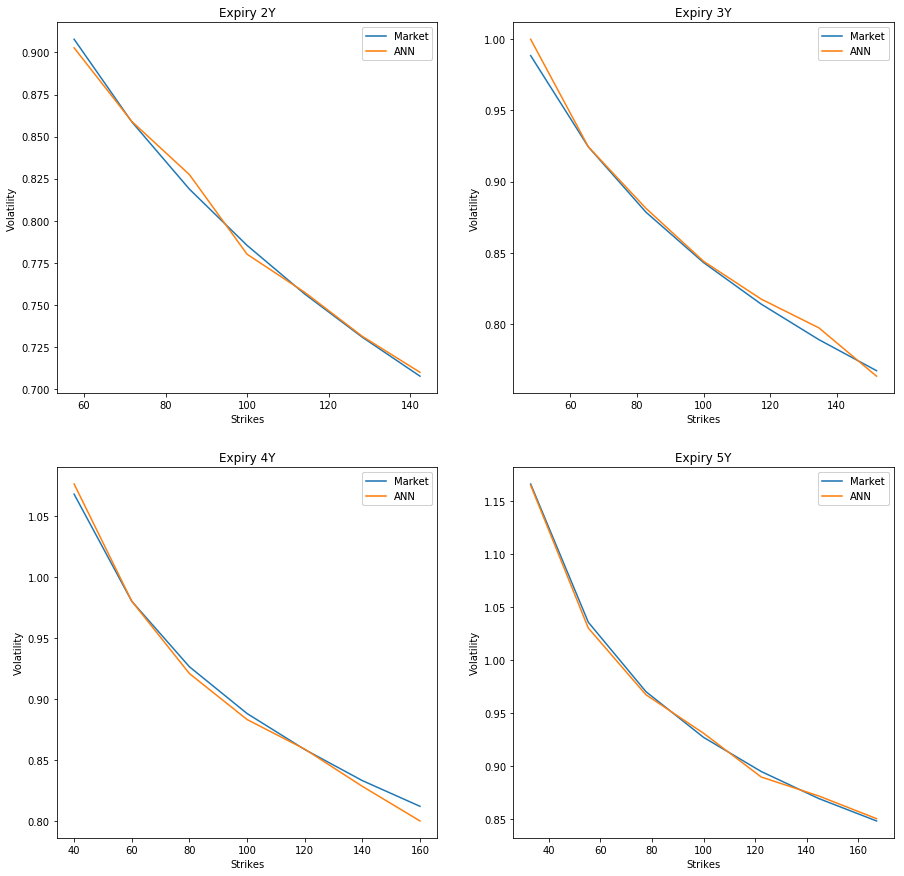

In [164]:
#fig = plt.figure()
#ax = fig.gca(projection='3d')
X = np.reshape(np.tile(Expiries,len(BaseStrikes)),(len(BaseStrikes),len(Expiries)))
Y = np.reshape(np.array(Strikes),(len(BaseStrikes),len(Expiries)))
Z_INIT = np.reshape(iv[0],(len(BaseStrikes),len(Expiries)))
Z_ANN = np.reshape(ann_iv,(len(BaseStrikes),len(Expiries)))
#print(X)
#print(Y)
#print(Z)
#surf = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)

plt.figure(figsize=(15,15))
plt.figure(1)
current_num=221
for k in range(4):
    plt.subplot(current_num)
    line1, = plt.plot(Y[:,k+6],Z_INIT[:,k+6],label="Market")
    plt.xlabel("Strikes")
    plt.ylabel("Volatility")
    plt.title("Expiry " + str(k+2) + "Y")
    line2, = plt.plot(Y[:,k+6],Z_ANN[:,k+6],label="ANN")
    plt.xlabel("Strikes")
    plt.ylabel("Volatility")
    plt.gca().add_artist(plt.legend(handles=[line1,line2]))
    #plt.gca().add_artist(plt.legend(handles=[line2],loc=7))
    current_num = current_num+1

plt.show()